## Package Usage Example
- [Getting Data](#getting-data)
- [Create Dataset](#create-dataset-and-dataloader)
- [Create Transfert Learning Model](#create-transfert-learning-model)
- [Create Optimizer, Loss and Metric Function for Training](#create-optimizer-loss-and-metric-function)
- [Training and Get History](#training-and-get-the-history)
- [History Details](#history-details)
***

### Getting Data

In [1]:
import wget
from zipfile import ZipFile
from pathlib import Path

def download_and_extract_zip_into_folder(
    zip_url : str,
    data_dir : str = "data/"
)->None:
    """Download and Extract Zip Url into target folder

    Args:
        zip_url (str): url of zip file
        data_dir (str, optional): folder to extract data. Defaults to "data/".
    """
    data_path = Path(data_dir)
    zip_name = Path(zip_url).stem
    
    # Setup new folder path into data folder
    new_folder_path = data_path / zip_name

    # If the new folder doesn't exist, download it and prepare it... 
    if new_folder_path.is_dir():
        print(f"[INFO] : {new_folder_path} directory exists, do nothing.")

    else:
        print(f"[INFO] : Creating {new_folder_path} directory")
        new_folder_path.mkdir(parents=True, exist_ok=True)

        # Download zip file
        zip_file = wget.download(zip_url)
        print(f"[INFO] : Download {zip_file}")
        zip_file = Path(zip_file)
        
        # Unzip zipfile in new folder
        ziper = ZipFile(zip_file)
        ziper.extractall(new_folder_path)
        print(f"[INFO] : Extract {zip_file} here : {new_folder_path}")

        # Remove zip File
        print(f"[INFO] : Remove {zip_file}...")
        zip_file.unlink()
    
    return (new_folder_path)

In [2]:
download_and_extract_zip_into_folder(
    zip_url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    data_dir="data/",
)

[INFO] : data/pizza_steak_sushi_20_percent directory exists, do nothing.


PosixPath('data/pizza_steak_sushi_20_percent')

In [3]:
from pathlib import Path
 
# Setup train and testing paths
PARENT_FOLDER = Path("data/pizza_steak_sushi_20_percent")

TRAIN_DIR = PARENT_FOLDER / "train"
TEST_DIR = PARENT_FOLDER / "test"

PARENT_FOLDER, TRAIN_DIR, TEST_DIR

(PosixPath('data/pizza_steak_sushi_20_percent'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

***

### Create Dataset and Dataloader
- Import `EfficientNetB0` Pretrained Weight and Image transformer

In [4]:
from torchvision.models import EfficientNet_B0_Weights
from torchvision.models import efficientnet_b0

# Get the Weight of Model `DEFAULT` == last best version
weights = EfficientNet_B0_Weights.DEFAULT

preprocessing = weights.transforms()

# Give Weight to model architecture
efficientnetb0 = efficientnet_b0(weights=weights)

In [5]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=TRAIN_DIR,
                            transform=preprocessing)

test_dataset = ImageFolder(root=TEST_DIR,
                           transform=preprocessing)

len(train_dataset), len(test_dataset)

(450, 150)

In [6]:
from torch.utils.data import DataLoader
import os 

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True 
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

len(train_dataloader), len(test_dataloader)

(15, 5)

***

### Create Transfert Learning Model
Converting `EfficientNetB0` to Feature Extractor
- Create a custom `Module` Pytorch with :
- Frozen all parameters
- Change Head of Model `classifier`

In [7]:
from torch.nn import Module

def frozen_module_parameters(module : Module)->Module:
    """Frozen all Module parameters

    Args:
        module (Module): Module

    Returns:
        Module: New Module with all requires_grad = False
    """
    for parameter in module.parameters():
        parameter.requires_grad = False
    
    return (module)

In [8]:
from torch.nn import Sequential, Dropout, Linear

efficientnetb0_feature_extractor = frozen_module_parameters(module=efficientnetb0) 
efficientnetb0_feature_extractor.classifier = Sequential(
    Dropout(p=0.2),
    Linear(in_features=1280, out_features=3)
)

In [9]:
from torchinfo import summary

summary(model=efficientnetb0_feature_extractor, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

***

- define the device where training the model

In [10]:
import torch 

### Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

efficientnetb0_feature_extractor.to(device)
print(f"Using device: {device}")

Using device: cuda


***

### Create Optimizer Loss and Metric Function

In [11]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torchmetrics.classification import F1Score


metric_function = F1Score(task="multiclass", num_classes=3)
optimizer = Adam(efficientnetb0_feature_extractor.parameters(), lr=0.01)
loss_function = CrossEntropyLoss()

***

### Training and Get the History

  0%|          | 0/10 [00:00<?, ?it/s]

Epochs            | Train Loss        | Train Accuracy    | Val Loss          | Val Accuracy      |
10.0% [1/10]      | 0.5392            | 0.7875            | 0.2844            | 0.8864            |
-----------------------------------------------------------------------------------------------
20.0% [2/10]      | 0.3139            | 0.9062            | 0.2105            | 0.9159            |
-----------------------------------------------------------------------------------------------
30.0% [3/10]      | 0.2444            | 0.8854            | 0.2776            | 0.8972            |
-----------------------------------------------------------------------------------------------
40.0% [4/10]      | 0.3024            | 0.8771            | 0.2641            | 0.8892            |
-----------------------------------------------------------------------------------------------
50.0% [5/10]      | 0.1502            | 0.9333            | 0.1869            | 0.9131            |
----------------

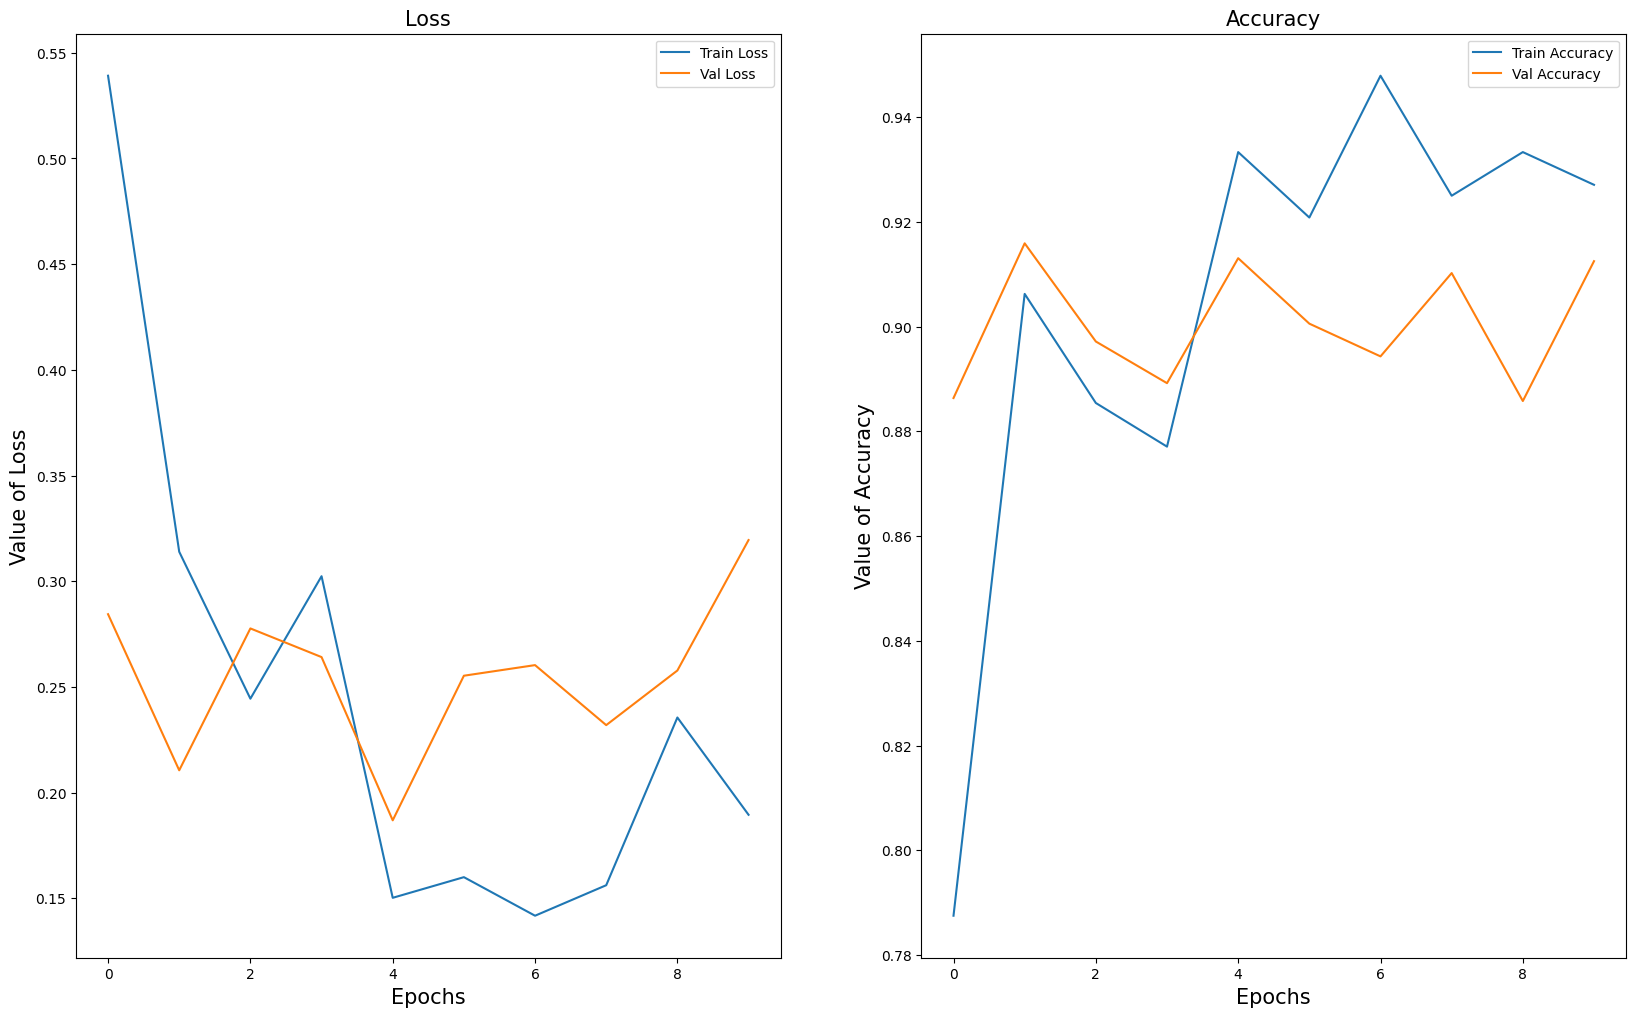

In [12]:
from training.core import train

history = train(
    model=efficientnetb0_feature_extractor,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    metric_function=metric_function,
    device=device,
    epochs=10
)

***

### History Details

In [17]:
from pprint import pprint
pprint(history, sort_dicts=False)

{'Epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'Train Loss': [0.53915702799956,
                0.313928813735644,
                0.2444056861102581,
                0.30235722015301386,
                0.15019742734730243,
                0.15996762439608575,
                0.1417218826711178,
                0.15615219374497732,
                0.23551132815579573,
                0.18948346860706805],
 'Train Accuracy': [0.7875,
                    0.90625,
                    0.8854166666666666,
                    0.8770833333333333,
                    0.9333333333333333,
                    0.9208333333333333,
                    0.9479166666666666,
                    0.925,
                    0.9333333333333333,
                    0.9270833333333334],
 'Val Loss': [0.28438338860869405,
              0.2105265773832798,
              0.2776483118534088,
              0.2640878982841969,
              0.18685874193906785,
              0.2552743200212717,
              0.260294

In [15]:
num_epochs = len(history["Epochs"])
last_train_accuracy = history["Train Accuracy"][-1]
last_test_accuracy = history["Val Accuracy"][-1]
underfitting_diagnostic = history["Bias and UnderFitting"]
overfitting_diagnostic = history["Variance and OverFitting"]
training_time = history["Training Time"]
experiment_figures = [history["Curve Figure"]]